# Impact of Neighborhood on Amazon HQ2 selection

###   *Will good neighborhood attract new business office for Unicorn companies*


## Introduction

Amazon announced the process to look for the 2nd headquarter in 2017, it led to a hot wave of biding on this proposal from 54 states, provinces, districts, and territories due to the huge financial and job potentials. 200 cities entered the final list. Among the 20 cities in the final lists, Long Island, New York and Crystal city, Virginia were selected as the locations for 2nd headquarters in Nov, 2018. Due to objection from various political parties, Amazon has canceled the selection Long Island NY in early 2019 while the development at Crystal city VA is still undergoing.

While Amazon has laid down the requirement for the 2HQ selection, such as Metropolitan areas with certain populations, close to popular center and highway/airport, availability of talents, financial incentives etc,  it will be interesting to check if the neighborhood of candidate locations/cities is an important criteria.  For example, does the 2HQ have similar neighborhood as that in current HQ in Seattle, WA? If the neighborhood similarity  plays significant role in 2HQ selection, it will provide enough information for cities/territories authorities to set a strategic approach to attract new businesses in future. 

## Table of Contents
- Download and Explore Dataset

- Explore Neighborhoods in New York City(including Long island city, NY), Arlington VA/Washington DC (including Crystal City) and Seattle, WA

- Preparation of Neighborhood venues data for clustering 

- Cluster Neighborhoods

- Compare the similarity of Neighborhoods in three locations



## Methodology
   
   The neighborhood info or list for three cities, Seattle WA, Arlington VA and Queens, NY can be obtained from open data source or Wiki website. Then the latitude and longitude information for each neighborhood ca been obtained using geopy package. After consolidation of all datasets, the top 100 popular venues from each neighborhood can be retrieved usign Four Square API. Then K-cluster algorithm will be used to cluster all neighborhood. Finally the similarity of neighborhood from each cities will be compared to check how much of similar neighborhood from 3 cities. This will lead to conclusion regarding the impact of neighborhood similarity on Amazon 2HQ selection.
   
   
   
## Download and Explore Dataset 

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import numpy as np 

import pandas as pd 
import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt


# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

#!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### Download the neighborhood list from [Seattle gov website](https://www.seattle.gov/neighborhoods/neighborhoods-and-districts) and save as Seattle_Neighborhood.csv file. Load the file into a dataframe

In [2]:
df_seattle= pd.read_csv('Seattle_Neighborhood.csv')
df_seattle.head()

,Neighborhood,City
0,23rd & Union/Jackson,Seattle
1,Admiral,Seattle
2,Aurora-Licton Springs,Seattle
3,Ballard,Seattle
4,Beacon Hill,Seattle


In [3]:
# define a function to get latitide and longitude based on an address


def is_empty(any_structure):
    if any_structure:
        return False
    else:
        return True   

    
def get_geospatial_data(Neighborhood, city, state):
    address = Neighborhood + ',' + city +','+ state 
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    if is_empty(location):
        return ['NaN', 'NaN']
    else: 
        return [location.latitude, location.longitude] 

In [4]:
# obtain the latidute and longitude data and add into data frame
SA_latitude =[]
SA_longitude=[]


for i in df_seattle['Neighborhood']:
    i=i.split('/')[0] 
    i=i.split('-')[0]
    if 'Junction' in i:
        i=i.strip('Junction')
    if 'Commercial Core' in i:
        i=i.strip('Commericial Core')
    geo_info = get_geospatial_data(i, 'Seattle', 'WA') 
    SA_latitude.append(geo_info[0])
    SA_longitude.append(geo_info[1])                              
    
df_seattle['Latitude']=SA_latitude
df_seattle['Longitude']=SA_longitude

df_seattle.head()


,Neighborhood,City,Latitude,Longitude
0,23rd & Union/Jackson,Seattle,47.612866,-122.301835
1,Admiral,Seattle,47.581195,-122.386546
2,Aurora-Licton Springs,Seattle,47.603832,-122.330062
3,Ballard,Seattle,47.676507,-122.386223
4,Beacon Hill,Seattle,47.579258,-122.311598


In [5]:
#check if the latidude and longitude is unique for each neighborhood
df_seattle.nunique()

Neighborhood    40
City             1
Latitude        40
Longitude       40
dtype: int64

### Run the same procedure for Arlington, VA

In [6]:
# read the neighborhood name of Arlington from csv file obtained from Wiki page
df_arlington= pd.read_csv('Arlington_Neighborhood.csv')


# obtain the latidute and longitude data and add into data frame
AR_latitude =[]
AR_longitude=[]


for i in df_arlington['Neighborhood']:
    i=i.split('/')[0] 
    i=i.split('-')[0]
    geo_info = get_geospatial_data(i, 'Arlington', 'VA') 
    AR_latitude.append(geo_info[0])
    AR_longitude.append(geo_info[1])  
    
df_arlington['Latitude']=AR_latitude
df_arlington['Longitude']=AR_longitude

df_arlington.head()




,Neighborhood,City,Latitude,Longitude
0,Alcova Heights,Arlington,38.8646,-77.0972
1,Arlington Forest,Arlington,38.8689,-77.1131
2,Arlington Heights,Arlington,38.8696,-77.0922
3,Arlington Ridge,Arlington,40.984,-81.4939
4,Arlington View / Johnson's Hill,Arlington,38.8631,-77.0726


In [7]:
#Drop the Neighborhood with no latitude data
# Need to consolidate the neighboorhood with same latitide and longtiude and drop the Neighborhood with no latitude data
df_arlington_new=df_arlington.groupby(['City', 'Latitude', 'Longitude'], as_index=False, sort =False)[['Neighborhood']].agg('/'.join)
df_arlington_new.drop(df_arlington_new[df_arlington_new['Longitude']=='NaN'].index, inplace =True, axis=0)
df_arlington_new.reset_index(drop=True, inplace=True)
print(df_arlington_new.nunique())

# one hot code to fix the columns order
fixed_columns = [df_arlington_new.columns[-1]] + list(df_arlington_new.columns[:-1])

df_arlington_final = df_arlington_new[fixed_columns]

print (df_arlington_final.shape)
df_arlington_final.head()

City             1
Latitude        52
Longitude       52
Neighborhood    52
dtype: int64
(52, 4)


,Neighborhood,City,Latitude,Longitude
0,Alcova Heights,Arlington,38.8646,-77.0972
1,Arlington Forest,Arlington,38.8689,-77.1131
2,Arlington Heights,Arlington,38.8696,-77.0922
3,Arlington Ridge,Arlington,40.984,-81.4939
4,Arlington View / Johnson's Hill,Arlington,38.8631,-77.0726


### Since crytal city is next to Washington DC, it is reasonable to add [DC data](http://opendata.dc.gov/datasets/neighborhood-labels/data)

In [8]:
# load the data into a dataframe
df_DC_rawdata= pd.read_csv('DC_Neighborhood_Labels.csv')
df_DC_rawdata.head()

,X,Y,OBJECTID,GIS_ID,NAME,WEB_URL,LABEL_NAME,DATELASTMODIFIED
0,-77.007767,38.925776,1,nhood_132,Stronghold,http://op.dc.gov,Stronghold,2003-04-10T00:00:00.000Z
1,-76.972367,38.901336,2,nhood_134,Langston,http://op.dc.gov,Langston,2003-04-10T00:00:00.000Z
2,-77.014234,38.895428,3,nhood_137,Downtown East,http://op.dc.gov,Downtown \r\nEast,2003-04-10T00:00:00.000Z
3,-77.041094,38.986790,4,nhood_029,Colonial Village,http://op.dc.gov,Colonial \r\nVillage,2003-04-10T00:00:00.000Z
4,-77.032126,38.982980,5,nhood_109,Shepherd Park,http://op.dc.gov,Shepherd \r\nPark,2003-04-10T00:00:00.000Z


In [9]:
#creat DC  neighborhood data with the same format as Arlington dataset
column_names =['Neighborhood', 'City', 'Latitude', 'Longitude'] 
df_DC=pd.DataFrame(columns=column_names)

df_DC['Neighborhood']=df_DC_rawdata['NAME']
df_DC['City']='DC'
df_DC['Latitude']=df_DC_rawdata['Y']
df_DC['Longitude']=df_DC_rawdata['X']
df_DC.head()

,Neighborhood,City,Latitude,Longitude
0,Stronghold,DC,38.925776,-77.007767
1,Langston,DC,38.901336,-76.972367
2,Downtown East,DC,38.895428,-77.014234
3,Colonial Village,DC,38.986790,-77.041094
4,Shepherd Park,DC,38.982980,-77.032126


In [10]:
# Combine Arlington and DC dataset into one dataset as df_arlingtonDC
df_arlingtonDC = pd.concat([df_arlington_final,df_DC], ignore_index=True, sort=False)

# repalce the City name with Arlington/DC
df_arlingtonDC['City'].replace(to_replace=['Arlington', 'DC'], value='Arlington/DC', inplace =True)

print (df_arlingtonDC.shape)
print (df_arlingtonDC.nunique())
df_arlingtonDC.head

(183, 4)
Neighborhood    181
City              1
Latitude        183
Longitude       183
dtype: int64


<bound method NDFrame.head of                         Neighborhood          City Latitude Longitude
0                     Alcova Heights  Arlington/DC  38.8646  -77.0972
1                   Arlington Forest  Arlington/DC  38.8689  -77.1131
2                  Arlington Heights  Arlington/DC  38.8696  -77.0922
3                    Arlington Ridge  Arlington/DC   40.984  -81.4939
4    Arlington View / Johnson's Hill  Arlington/DC  38.8631  -77.0726
5                       Aurora Hills  Arlington/DC  38.8515  -77.0641
6                           Ballston  Arlington/DC  38.8831  -77.1101
7                           Barcroft  Arlington/DC  38.8559  -77.1039
8                    Bellevue Forest  Arlington/DC  38.9143  -77.1136
9                           Bluemont  Arlington/DC  38.8747   -77.133
10                            Bonair  Arlington/DC   38.876  -77.1335
11                   Brandon Village  Arlington/DC  38.8757  -77.1158
12                        Buckingham  Arlington/DC  38.8734 

### Long island city is a neighborhood belonging to Queens borough and is close to Manhattan.  So it is possible to use this [New York Geospatial json file](https://cocl.us/new_york_dataset) to get the geo info  Queens neighborhoods and Manhattan neighborhoods

In [11]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
newyork_neighborhood = newyork_data['features']

#### Transfer data into DataFeame and extract the neighborhood data from Borough Queens

In [12]:
#column_names =['Neighborhood', 'City', 'Latitude', 'Longitude'] 

# instantiate the dataframe
NY_neighborhoods = pd.DataFrame(columns=column_names)

# get the neighborhood data geo data for NY boroughs
for data in newyork_neighborhood:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    NY_neighborhoods = NY_neighborhoods.append({'Neighborhood': neighborhood_name,
                                          'City': borough,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
NY_neighborhoods.head()


,Neighborhood,City,Latitude,Longitude
0,Wakefield,Bronx,40.894705,-73.847201
1,Co-op City,Bronx,40.874294,-73.829939
2,Eastchester,Bronx,40.887556,-73.827806
3,Fieldston,Bronx,40.895437,-73.905643
4,Riverdale,Bronx,40.890834,-73.912585


In [13]:
#extarct the information of queens and Manhanttan borough
df_NY= NY_neighborhoods.loc[NY_neighborhoods['City'].isin(['Queens','Manhattan'])]
df_NY.head()

,Neighborhood,City,Latitude,Longitude
6,Marble Hill,Manhattan,40.876551,-73.910660
100,Chinatown,Manhattan,40.715618,-73.994279
101,Washington Heights,Manhattan,40.851903,-73.936900
102,Inwood,Manhattan,40.867684,-73.921210
103,Hamilton Heights,Manhattan,40.823604,-73.949688


In [14]:
# repalce the City name with New York
df_NY['City'].replace(to_replace=['Manhattan', 'Queens'], value='New York', inplace =True)

print(df_NY.nunique())

print(df_NY.shape)

df_NY.head()

Neighborhood    120
City              1
Latitude        121
Longitude       121
dtype: int64
(121, 4)


C:\Users\bt6315\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,Neighborhood,City,Latitude,Longitude
6,Marble Hill,New York,40.876551,-73.910660
100,Chinatown,New York,40.715618,-73.994279
101,Washington Heights,New York,40.851903,-73.936900
102,Inwood,New York,40.867684,-73.921210
103,Hamilton Heights,New York,40.823604,-73.949688


### Now merge the neighboorhoods data from 3 cities together to form final dataset for data analysis 

In [168]:
df_combine_neighborhood = pd.concat([df_seattle, df_arlingtonDC,df_NY], ignore_index=True, sort=False)

df_combine_neighborhood


,Neighborhood,City,Latitude,Longitude
0,23rd & Union/Jackson,Seattle,47.6129,-122.302
1,Admiral,Seattle,47.5812,-122.387
2,Aurora-Licton Springs,Seattle,47.6038,-122.33
3,Ballard,Seattle,47.6765,-122.386
4,Beacon Hill,Seattle,47.5793,-122.312
5,Belltown,Seattle,47.6132,-122.345
6,Bitter Lake/Broadview,Seattle,47.7266,-122.352
7,Capitol Hill,Seattle,47.6238,-122.318
8,Chinatown-International District,Seattle,47.5992,-122.323
9,Columbia City,Seattle,47.5579,-122.285


In [169]:
print(df_combine_neighborhood.nunique())
print(df_combine_neighborhood.shape)

print(df_combine_neighborhood.describe(include='all'))

Neighborhood    336
City              3
Latitude        344
Longitude       344
dtype: int64
(344, 4)
        Neighborhood          City    Latitude   Longitude
count            344           344  344.000000  344.000000
unique           336             3  344.000000  344.000000
top     Forest Hills  Arlington/DC   47.526468  -77.108312
freq               3           183    1.000000    1.000000


In [170]:
df_combine_neighborhood.groupby(['Neighborhood', 'City']).count()

,,Latitude,Longitude
Neighborhood,City,,
16th Street Heights,Arlington/DC,1,1
23rd & Union/Jackson,Seattle,1,1
Adams Morgan,Arlington/DC,1,1
Admiral,Seattle,1,1
Alcova Heights,Arlington/DC,1,1
American University Park,Arlington/DC,1,1
Arboretum,Arlington/DC,1,1
Arlington Forest,Arlington/DC,1,1
Arlington Heights,Arlington/DC,1,1


In [18]:
#Save the final dataset as AmazonHQ_Geo_info_cvs

with open('AmazonHQ_Geo_info.csv', 'w') as writefile:
    df_combine_neighborhood.to_csv(writefile, index=False, sep=';', encoding='utf-8')

### Creat maps for 3 HQ cities

In [190]:
# create map of Seattle using latitude and longitude values

seattle_location= get_geospatial_data('Seattle', 'WA', 'USA')
map_seattle = folium.Map(location=[seattle_location[0], seattle_location[1]], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_seattle['Latitude'], df_seattle['Longitude'], df_seattle['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_seattle)  
    
map_seattle

In [20]:
# create map of Arlington/DC using latitude and longitude values

arlington_location= get_geospatial_data('Arlington', 'VA', 'USA')
map_arlingtonDC = folium.Map(location=[arlington_location[0], arlington_location[1]], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_arlingtonDC['Latitude'], df_arlingtonDC['Longitude'], df_arlingtonDC['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_arlingtonDC)  
    
map_arlingtonDC

In [21]:
# create map of Queens, NY using latitude and longitude values

queens_location= get_geospatial_data('Queens', 'NY', 'USA')
map_NY = folium.Map(location=[queens_location[0], queens_location[1]], zoom_start=10)

# add markers to map
for lat, lng, label in zip(df_NY['Latitude'], df_NY['Longitude'], df_NY['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NY)  
    
map_NY

## Preparation of Neighborhood venues data for clustering 

### Define Foursquare Credentials and Version

In [39]:
# @hidden_cell
#Define Foursquare Credentials and Version
CLIENT_ID = 'JPNYELKZIJOED3AGYYEFXH05WBF4DTDD5DAJNGVTXY5T0POU' 
CLIENT_SECRET = 'GGTZCULZXYVKKSZELHGIG2EDGXGLZE30G44F5ESJVEUGFJGZ' 
VERSION = '20190501' # Foursquare API version

### Create a function to explor top 100 venues near a Neighborhood, then explore the top100 venues at each neighborhood

In [40]:
#create a function to explor top 100 venues near a Neighborhood
def getNearbyVenues(names, cities, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, city, lat, lng in zip(names, cities, latitudes, longitudes):
        print(name, ' ', city)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            city,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                  'City',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [41]:
# run the above function on each neighborhood and create a new dataframe called HQ_venues.

HQ_venues = getNearbyVenues(names= df_combine_neighborhood['Neighborhood'],
                                   cities=df_combine_neighborhood['City'],
                                   latitudes= df_combine_neighborhood['Latitude'],
                                   longitudes= df_combine_neighborhood['Longitude'],
                                 radius=500 )

23rd & Union/Jackson   Seattle
Admiral   Seattle
Aurora-Licton Springs   Seattle
Ballard   Seattle
Beacon Hill   Seattle
Belltown   Seattle
Bitter Lake/Broadview   Seattle
Capitol Hill   Seattle
Chinatown-International District   Seattle
Columbia City   Seattle
Crown Hill   Seattle
Delridge   Seattle
Downtown Commercial Core   Seattle
Eastlake   Seattle
First Hill   Seattle
Fremont   Seattle
Georgetown   Seattle
Green Lake   Seattle
Greenwood-Phinney Ridge   Seattle
Judkins Park   Seattle
Lake City   Seattle
Madison-Miller   Seattle
Magnolia   Seattle
Montlake   Seattle
Morgan Junction   Seattle
North Rainier / Mount Baker   Seattle
Northgate   Seattle
Othello   Seattle
Pioneer Square   Seattle
Queen Anne   Seattle
Rainier Beach   Seattle
Roosevelt   Seattle
Sand Point   Seattle
South Lake Union   Seattle
South Park   Seattle
University District   Seattle
Uptown   Seattle
Wallingford   Seattle
West Seattle Junction   Seattle
Westwood Village / Roxhill-Highland Park   Seattle
Alcova Hei

Hillcrest   New York
Ravenswood   New York
Lindenwood   New York
Laurelton   New York
Lefrak City   New York
Belle Harbor   New York
Rockaway Park   New York
Somerville   New York
Brookville   New York
Bellaire   New York
North Corona   New York
Forest Hills Gardens   New York
Carnegie Hill   New York
Noho   New York
Civic Center   New York
Midtown South   New York
Jamaica Hills   New York
Utopia   New York
Pomonok   New York
Astoria Heights   New York
Sutton Place   New York
Hunters Point   New York
Turtle Bay   New York
Tudor City   New York
Stuyvesant Town   New York
Flatiron   New York
Sunnyside Gardens   New York
Blissville   New York
Roxbury   New York
Middle Village   New York
Malba   New York
Hudson Yards   New York
Hammels   New York
Bayswater   New York
Queensbridge   New York


In [42]:
print(HQ_venues.shape)
HQ_venues.head()

(10734, 8)


,Neighborhood,City,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,23rd & Union/Jackson,Seattle,47.612866,-122.301835,Uncle Ike's CD,47.613135,-122.301686,Alternative Healer
1,23rd & Union/Jackson,Seattle,47.612866,-122.301835,Raised Doughnuts,47.611767,-122.302825,Donut Shop
2,23rd & Union/Jackson,Seattle,47.612866,-122.301835,Central Cinema,47.613319,-122.305280,Indie Movie Theater
3,23rd & Union/Jackson,Seattle,47.612866,-122.301835,Tacos Chukis,47.612894,-122.302945,Taco Place
4,23rd & Union/Jackson,Seattle,47.612866,-122.301835,Squirrel Chops,47.612880,-122.303361,Coffee Shop


In [43]:
HQ_venues.groupby(['Neighborhood','City']).count()

,,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,City,,,,,,
16th Street Heights,Arlington/DC,15,15,15,15,15,15
23rd & Union/Jackson,Seattle,37,37,37,37,37,37
Adams Morgan,Arlington/DC,76,76,76,76,76,76
Admiral,Seattle,42,42,42,42,42,42
Alcova Heights,Arlington/DC,5,5,5,5,5,5
American University Park,Arlington/DC,2,2,2,2,2,2
Arboretum,Arlington/DC,14,14,14,14,14,14
Arlington Forest,Arlington/DC,7,7,7,7,7,7
Arlington Heights,Arlington/DC,5,5,5,5,5,5


In [48]:
# Save the retrieved venues file into "AmazonHQ_Venues_info.csv"

with open('AmazonHQ_Venues_info.csv', 'w', encoding="utf-8") as writefile:
    HQ_venues.to_csv(writefile, index=False, sep=';')

### Convert the vennue category to an new dataframe for clustering. 
<b> **: There is a category named "Neoghborhood".  So use the "Neighborhoods" as the column name for real Neighborhood data. </b>

In [171]:
# one hot encoding
HQ_onehot = pd.get_dummies(HQ_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhoods and cities column back to dataframe
HQ_onehot['Neighborhoods'] = HQ_venues['Neighborhood'] 
HQ_onehot['City'] = HQ_venues['City']

# move neighborhoods column to the first column
fixed_columns = [HQ_onehot.columns[-2]] + [HQ_onehot.columns[-1]] +list(HQ_onehot.columns[:-2])

HQ_onehot = HQ_onehot[fixed_columns]
HQ_onehot.head()

,Neighborhoods,City,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,Alternative Healer,American Restaurant,...,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,23rd & Union/Jackson,Seattle,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,23rd & Union/Jackson,Seattle,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,23rd & Union/Jackson,Seattle,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,23rd & Union/Jackson,Seattle,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,23rd & Union/Jackson,Seattle,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Group rows by neighborhood/city and by taking the mean of the frequency of occurrence of each category

In [182]:
#group rows by neighborhood/city and by taking the mean of the frequency of occurrence of each category

HQ_grouped = HQ_onehot.groupby(['Neighborhoods', 'City']).mean().reset_index()
print (HQ_grouped.shape)
HQ_grouped.head()

(340, 456)


,Neighborhoods,City,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,Alternative Healer,American Restaurant,...,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,16th Street Heights,Arlington/DC,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,23rd & Union/Jackson,Seattle,0.0,0.0,0.0,0.000000,0.0,0.0,0.027027,0.00000,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Adams Morgan,Arlington/DC,0.0,0.0,0.0,0.013158,0.0,0.0,0.000000,0.00000,...,0.013158,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Admiral,Seattle,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.02381,...,0.000000,0.02381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Alcova Heights,Arlington/DC,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Use the K-means to segment the neighborhoods for 3 HQ cities

### Determine the optimal cluster number using elbow method

In [183]:
# Drop first two columns from HQ_grouped dataframe
HQ_clustering = HQ_grouped.drop(['Neighborhoods', 'City'], axis =1)


In [87]:
# find the optimal clustering value with elbow and silhoutte scorce
Sum_of_squared_distances = []
savg = []
K = range(2,21)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(HQ_clustering)
    Sum_of_squared_distances.append(km.inertia_)
    clusterlabels =km.predict(HQ_clustering)
    s_avg_score= silhouette_score(HQ_clustering, clusterlabels)
    savg.append(s_avg_score)

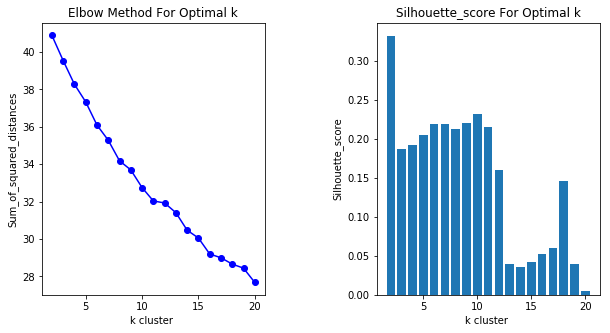

In [88]:
# plot the cluster number with Sum_of_squared_distances and silhouette_score

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.subplots_adjust(wspace=0.5)

ax = axs[0]
ax.plot(K, Sum_of_squared_distances, 'bo-')
ax.set_title('Elbow Method For Optimal k')
ax.set_xlabel('k cluster ')
ax.set_ylabel('Sum_of_squared_distances')


ax = axs[1]
ax.bar(K,savg )
ax.set_title('Silhouette_score For Optimal k')
ax.set_xlabel('k cluster ')
ax.set_ylabel('Silhouette_score')

plt.show()

#### K cluster number cannot be identified by Sum of suqared distance, but the Silhuuette_score indicate k=10 is reasoble cluster number.


In [185]:
# segment all neighborhoods in 10 clusters

k_cluster = 10
km = KMeans(n_clusters=k_cluster).fit(HQ_clustering)
km.labels_[0:50]

array([8, 8, 8, 8, 3, 9, 8, 8, 3, 8, 8, 8, 8, 8, 8, 2, 8, 8, 8, 8, 2, 0,
       8, 8, 8, 2, 8, 8, 1, 8, 8, 8, 2, 8, 3, 3, 8, 8, 8, 2, 2, 8, 8, 8,
       1, 8, 8, 1, 8, 1])

In [186]:
# insert the cluster label back to the grouped data 
HQ_grouped.insert(0, 'Cluster label', km.labels_)
HQ_grouped.head()

,Cluster label,Neighborhoods,City,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,Alternative Healer,...,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,8,16th Street Heights,Arlington/DC,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8,23rd & Union/Jackson,Seattle,0.0,0.0,0.0,0.000000,0.0,0.0,0.027027,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8,Adams Morgan,Arlington/DC,0.0,0.0,0.0,0.013158,0.0,0.0,0.000000,...,0.013158,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8,Admiral,Seattle,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.02381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,Alcova Heights,Arlington/DC,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [187]:
# insert a key colume with "neighborhood"+"city" in the HQ_gruop_labels and df_combined_Neighborhood

df_combine_neighborhood['key']=df_combine_neighborhood['Neighborhood'].str.cat(df_combine_neighborhood['City'], sep=',')
df_combined_Neighborhood_temp=df_combine_neighborhood.drop(df_combine_neighborhood.iloc[:, 0:2], axis=1)
HQ_grouped_labels=HQ_grouped.drop(HQ_grouped.iloc[:, 3:], axis=1)
HQ_grouped_labels['key']=HQ_grouped_labels['Neighborhoods'].str.cat(HQ_grouped_labels['City'], sep=',')


In [188]:
# Then join the two dataframes together with key column as index, clean the merged dataframe by remove
#empty data and remove the 'key' index column


df_merge= HQ_grouped_labels.set_index('key').join(df_combined_Neighborhood_temp.set_index('key') )
df_merge.dropna(inplace=True)
df_merge.reset_index(drop=True, inplace=True)
print(df_merge.shape)
df_merge.head()

(343, 5)


,Cluster label,Neighborhoods,City,Latitude,Longitude
0,8,16th Street Heights,Arlington/DC,38.9503,-77.0336
1,8,23rd & Union/Jackson,Seattle,47.6129,-122.302
2,8,Adams Morgan,Arlington/DC,38.9205,-77.0424
3,8,Admiral,Seattle,47.5812,-122.387
4,3,Alcova Heights,Arlington/DC,38.8646,-77.0972


In [202]:
# save the clustered data into "AmazonHQ_cluster.csv"
with open('AmazonHQ_cluster.csv', 'w', encoding="utf-8") as writefile:
    df_merge.to_csv(writefile, index=False, sep=';')

##  Compare the similarity of Neighborhoods in three locations

In [189]:
# Get the labled data for each city

df_Seattle_labelled = df_merge[df_merge['City'] == 'Seattle']
df_ArlingtonDC_labelled = df_merge[df_merge['City'] == 'Arlington/DC']
df_NY_labelled = df_merge[df_merge['City'] == 'New York']

print(df_Seattle_labelled.shape)
print(df_Seattle_labelled.head())

print(df_ArlingtonDC_labelled.shape)
print(df_ArlingtonDC_labelled.head())


print(df_NY_labelled.shape)
print(df_NY_labelled.head())



(40, 5)
    Cluster label          Neighborhoods     City Latitude Longitude
1               8   23rd & Union/Jackson  Seattle  47.6129  -122.302
3               8                Admiral  Seattle  47.5812  -122.387
16              8  Aurora-Licton Springs  Seattle  47.6038   -122.33
17              8                Ballard  Seattle  47.6765  -122.386
26              8            Beacon Hill  Seattle  47.5793  -122.312
(182, 5)
   Cluster label             Neighborhoods          City Latitude Longitude
0              8       16th Street Heights  Arlington/DC  38.9503  -77.0336
2              8              Adams Morgan  Arlington/DC  38.9205  -77.0424
4              3            Alcova Heights  Arlington/DC  38.8646  -77.0972
5              9  American University Park  Arlington/DC  38.9476  -77.0902
6              8                 Arboretum  Arlington/DC  38.9149  -76.9725
(121, 5)
    Cluster label      Neighborhoods      City Latitude Longitude
11              8            Arverne  

In [197]:
# set color scheme for the clusters
x = np.arange(k_cluster)
ys = [i + x + (i*x)**2 for i in range(k_cluster)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


# define a function to draw maps
def drawMaps(citylocation, df_cluster):

    # create map
    map_clusters = folium.Map(location=[citylocation[0], citylocation[1]], zoom_start=11)

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(df_cluster['Latitude'], df_cluster['Longitude'], df_cluster['Neighborhoods'], df_cluster['Cluster label']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)
       
    return map_clusters

In [199]:
# Draw cluster maps for Seattles
drawMaps(seattle_location, df_Seattle_labelled)

In [200]:
# Draw cluster maps for Arlington/DC
drawMaps(arlington_location, df_ArlingtonDC_labelled)

In [201]:
# Draw cluster maps for New York
drawMaps(queens_location, df_NY_labelled)

## Conclusions: 

* All neigborhoods in there cities showed high similarity by clustering.
* The exact 3 amazon headquqrters locations (South lake union at Seattle, Crystal city at Arlington and Long island city at New York) are in same clutsers. 
* Fron this data, the neighborhood similarity night play an important role during the selection of 2nd HQ for Amazon. 
